In [24]:
import pandas as pd
import numpy as np
import datetime

In [25]:
mvc = pd.read_csv('NYPD_Motor_Vehicle_Collisions_processed_full.csv')

mvc.replace(['Unspecified', 'UNKNOWN'], np.nan, inplace=True)

# mvc.loc[:, mvc.columns.str.find('vType')!=-1]
# mvc.loc[1000:1100, 'cFactor1':]
# mvc.severity.value_counts()

#https://stackoverflow.com/questions/10741346/numpy-most-efficient-frequency-counts-for-unique-values-in-an-array/13232037
# x = np.array([1,1,1,2,2,2,5,25,1,1])
# unique, counts = np.unique(x, return_counts=True)
# np.asarray((unique, counts)).T
#
# array([[ 1,  5],
#        [ 2,  3],
#        [ 5,  1],
#        [25,  1]], dtype=int64)


mvc.dtime = mvc.dtime.map(lambda s: datetime.datetime.strptime(s, '%Y %b %d %a %H:%M'))
mvc.rename(columns={'dtime':'datetime'}, inplace=True) 
mvc.sort_values(by=['datetime', 'borough', 'lat', 'long'], inplace=True)

cols = mvc.columns.tolist()
cols.remove('datetime')
cols = ['datetime'] + cols
mvc = mvc[cols]
mvc.index = np.arange(len(mvc.index))

mvc.drop(['loc', 'year', 'month', 'hour', 'weekday'], axis=1, inplace=True)

mvc['datehour'] = mvc.datetime.map(lambda dtime: datetime.datetime(dtime.year, dtime.month, dtime.day, dtime.hour, 0, 0))

#mvc.to_csv('mvc_processed.csv')  # shape: (738586, 24)

In [26]:
# df.shape/dtypes/describe(include='all')
# df.index/values/cat/
# df.colname_.unique()/value_counts()
# df.isnull().sum()
# df.isnull()/notnull(): pd.isnull(df)/notnull(df)
#
# 
weather = pd.read_csv('NYC_Weather_KNYC.csv')

weather.drop(['lati','longi','station'], axis=1, inplace=True)
weather.replace('na', np.nan, inplace=True)
weather.replace('Unknown', np.nan, inplace=True)

weather['datetime'] = weather[['date', 'time']].apply(lambda tup: ' '.join(tup), axis=1)
weather.drop(['date', 'time'], axis=1, inplace=True)

weather.datetime = weather.datetime.map(lambda s: datetime.datetime.strptime(s, '%Y-%m-%d %I:%M %p'))
weather.sort_values(by='datetime', inplace=True)

weather['datehour'] = weather.datetime.map(lambda dtime: datetime.datetime(dtime.year, dtime.month, dtime.day, dtime.hour, 0, 0))
weather = weather.loc[(weather.datehour >= datetime.datetime(2013, 1, 1)) & (weather.datehour < datetime.datetime(2018, 1, 1)), : ]
weather.index = np.arange(weather.shape[0])

# move last datetime col to be the first col:
cols = weather.columns.tolist()
cols = cols[-1:] + cols[:-1] # move the last col to be the first
weather = weather[cols]
weather.index = np.arange(len(weather.index))

# change to float type:
# dewpoint,gustspeed,precip,pressure,temp,temp2,visi,windspeed
weather.iloc[:, [2, 4, 6, 7, 8, 9, 10, 12]] = weather.iloc[:, [2, 4, 6, 7, 8, 9, 10, 12]].astype(float)

weather['events'].replace(to_replace='[\n\t]', value='', regex=True, inplace=True)
weather.events = weather.events.str.split(pat=',').map(lambda lst: ' '.join(lst), na_action='ignore')

# define categorical data:
# 1. raw_cat = pd.Categorical(["a","b","c","a"], categories=["b","c","d"], ordered=False)
# 2. from pandas.api.types import CategoricalDtype
#    s = pd.Series(["a", "b", "c", "a"])
#    cat_type = CategoricalDtype(categories=["b", "c", "d"], ordered=True)
#    s_cat = s.astype(cat_type)
#


#------------------- try KNN imputation: not necessay for this weather dataset, ------------------
#                    as shown later next, for cols w/ too much missing data, we just have to drop them. 
#                    while for other cols, time interval linear interpolation for numeiric (already cover most of the missingness)
#                    and simple forward/backward fill covers the remaining not much missingness. 
# ------------------------------------------------------------------------------------------------
#                ... later, could try KNN to replace simple f/bfill part of the original imputation, and see how much can gain
#
# https://pypi.python.org/pypi/fancyimpute
# https://stackoverflow.com/questions/44822824/fancyimpute-pip-install-error
# change to cat type in names of number, for easy KNN imputation:

# for cat_key, cat_value in cat_dict.items():
#     weather[cat_key].cat.categories = np.arange(weather[cat_key].cat.categories.shape[0])
    # another way to rename cat names:
    # weather.conditions.cat.rename_categories(np.arange(weather.conditions.cat.categories.shape[0]), inplace=True)

#from fancyimpute import KNN
#%timeit weather_filled_knn = KNN(k=2).complete(weather.drop('datetime', 1)) #  and see...

# for cat_key, cat_value in cat_dict.items():
#     weather[cat_key].cat.categories = cat_value 

#df_numeric = df.select_dtypes(include=[np.float])
#df_filled.columns = df_numeric.columns
#df_filled.index = df_numeric.index
#--------------------------------------------------------------------------------------

#--- missingness check -----
# weather.shape: (59653, 12)
# weather.isnull().sum()

# datetime          0
# conditions      727
# dewpoint         37
# events        52422 <--- not reliable 
# gustspeed     49469 <--- not reliable
# humi             37
# precip        49407 <--- not reliable
# pressure        628
# temp             34
# temp2         39030 <--- not reliable
# visi            989
# winddir           0
# windspeed     14199
# dtype: int64

#--------------- impute for missing data in original weather data set ---------- 

# drop unreliable columns: too much missing data, no need to impute.
weather.drop(['events', 'gustspeed', 'precip', 'temp2'], axis=1, inplace=True) 


cat_dict = {'conditions': ['Clear', 'Scattered Clouds', 'Partly Cloudy', 'Mostly Cloudy', 'Overcast',\
                           'Light Rain', 'Rain', 'Heavy Rain',\
                           'Haze', 'Mist', 'Fog',\
                           'Light Snow', 'Snow', 'Heavy Snow', 'Light Freezing Rain', 'Light Freezing Fog'],
            #'events':     ['Fog', 'Rain', 'Fog Rain', 'Snow', 'Fog Snow'], 
            'winddir':    ['Calm', 'Variable', 'East', 'ESE', 'SE', 'SSE', \
                           'South', 'SSW', 'SW', 'WSW', \
                           'West', 'WNW', 'NW', 'NNW', \
                           'North', 'NNE', 'NE', 'ENE']
           }

for cat_key, cat_value in cat_dict.items():
    weather[cat_key] = pd.Categorical(weather[cat_key], categories=cat_value, ordered=True)
    
#-------- for now: simple imputation -----------
weather.set_index('datetime', inplace=True)

cols = [col for col in weather.columns if col not in cat_dict.keys()]

#--- time interval linear interpolation for numeric cols ----
for col in cols:
    weather[col].interpolate(method='time', inplace=True)

#--- naive forward/backward fill for categorical cols ---
for col in weather.columns:
    weather[col].fillna(method='ffill', inplace=True)
    weather[col].fillna(method='bfill', inplace=True)
                 
weather.reset_index(inplace=True)

In [298]:
#--------------- Don't run now! -------
#
#--------------- Way No. 1: impute for "exact-time" weather data for each mv collision record ----------

# mvc = pd.read_csv('mvc_processed.csv', , index_col=0)  # shape: (738586, 24)
# mvc['datetime'] = pd.to_datetime(mvc['datetime'])
# mvc['datehour'] = pd.to_datetime(mvc['datehour'])

# important to have the following unique() call on mvc datehour to eliminate so many duplications!
# otherwise, will all merge into weather, which is not desirable.
mvc_datetime = pd.DataFrame(pd.unique(mvc['datetime']), columns=['datetime'])

# merge mvc collision datetimes into weather data set:
weather_new = weather.merge(mvc_datetime, on='datetime', how='outer')

#
# impute for all the missing weather records for collision datetimes:
# still ran very fast.
#
weather_new.set_index('datetime', inplace=True)

cols = [col for col in weather_new.columns if col not in cat_dict.keys()]

#--- time interval linear interpolation for numeric cols ----
for col in cols:
    weather_new[col].interpolate(method='time', inplace=True)

#--- naive forward/backward fill for categorical cols ---
for col in weather_new.columns:
    weather_new[col].fillna(method='ffill', inplace=True)
    weather_new[col].fillna(method='bfill', inplace=True)
                 
weather_new.reset_index(inplace=True)

# merge weather data into mvc data set:
# now every collision record has weather data!
mvc = mvc.merge(weather_new, on='datetime', how='left')

# Just in case: 
# release memory from unused df:
del [weather_new]
import gc
gc.collect()

# dir() : check variables, dfs, data in current working space.

In [27]:
# best: join mvc collision df w/ hourly weather df at datetime w/ "closest" time interval/distance.
# how to join that way?
#
#

# some hours may have serveral recordings.
# in that caes, pick the top occurrence one for categorical variables
# and median for numeric variables.
top1 = lambda s: s.value_counts().nlargest(1).index[0] # this causes the most time consuming calc so far! slow down a lot.

colFun = {'conditions':[top1],
          'dewpoint':  ['median'], 
          'humi':      ['median'], 
          'pressure':  ['median'], 
          'temp':      ['median'], 
          'visi':      ['median'], 
          'windspeed': ['median'], 
          'winddir':   [top1]}

weather = weather.groupby('datehour').agg(colFun) # this causes the most time consuming calc so far! slow down a lot.

# https://stackoverflow.com/questions/22233488/pandas-drop-a-level-from-a-multi-level-column-index
weather.columns = weather.columns.droplevel(level=1)

weather.reset_index(inplace=True) # now 48742 rows × 9 columns

# weather.to_csv('weather_processed.csv')

#---------------Way No. 2: impute for "hourly" weather data for each mv collision record ----------

# important to have the following unique() call on mvc datehour to eliminate so many duplications!
# otherwise, will all merge into weather, which is not desirable.
mvc_datehour = pd.DataFrame(pd.unique(mvc['datehour']), columns=['datehour'])

weather = weather.merge(mvc_datehour, on='datehour', how='outer')

#
# impute for all the missing weather records for collision datetimes:
# still ran very fast.
#
weather.set_index('datehour', inplace=True)

cols = [col for col in weather.columns if col not in cat_dict.keys()]

#--- time interval linear interpolation for numeric cols ----
for col in cols:
    weather[col].interpolate(method='time', inplace=True)

#--- naive forward/backward fill for categorical cols ---
for col in weather.columns:
    weather[col].fillna(method='ffill', inplace=True)
    weather[col].fillna(method='bfill', inplace=True)
                 
weather.reset_index(inplace=True)

# merge weather data into mvc data set:
# now every collision record has weather data!
mvc = mvc.merge(weather, on='datehour', how='left')


# some more data cleaning: change some cols to categorical type:
# for easy bar graph ? ...
mvc['severity'].replace('lethal', 'fatal', inplace=True)

cols = [col for col in mvc.columns if col.find('cFactor') != -1 | col.find('vType') != -1]

mvc.loc[:, cols] = mvc.loc[:, cols].apply(lambda col: col.astype('category'), axis=0)

mvc_cat_dict = {'borough':  ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],\
                'severity': ['nohurt', 'injured', 'fatal']}

for cat_key, cat_value in cat_dict.items():
    mvc[cat_key] = pd.Categorical(mvc[cat_key], categories=cat_value, ordered=True)
    weather[cat_key] = pd.Categorical(weather[cat_key], categories=cat_value, ordered=True)
    
for cat_key, cat_value in mvc_cat_dict.items():
    mvc[cat_key] = pd.Categorical(mvc[cat_key], categories=cat_value, ordered=True)
    
#----------------- calculate severity index ------------------------
mvc['severity_index'] = np.repeat(1.0, mvc.shape[0])

mvc.loc[mvc.severity == 'injured', 'severity_index'] = \
        mvc.loc[mvc.severity == 'injured', 'totInj'].\
        map(lambda x: 2.55*x)
    
mvc.loc[mvc.severity == 'fatal', 'severity_index'] = \
        mvc.loc[mvc.severity == 'fatal', ['totKill', 'totInj']].\
        apply(lambda x: 7.55*x['totKill'] + 2.55*x['totInj'], axis=1)

In [23]:
mvc.head()

,datetime,borough,lat,long,totInj,totKill,pedInj,pedKill,cycInj,cycKill,...,winddir_x,severity_index,conditions_y,dewpoint_y,humi_y,pressure_y,temp_y,visi_y,windspeed_y,winddir_y
0,2013-01-01 00:01:00,Queens,40.761609,-73.882678,0,0,0,0,0,0,...,West,1.00,Overcast,24.1,55.0,29.87,39.0,10.0,10.4,West
1,2013-01-01 00:05:00,Manhattan,40.757732,-73.996852,0,0,0,0,0,0,...,West,1.00,Overcast,24.1,55.0,29.87,39.0,10.0,10.4,West
2,2013-01-01 00:07:00,Manhattan,40.720968,-73.982168,1,0,0,0,0,0,...,West,2.55,Overcast,24.1,55.0,29.87,39.0,10.0,10.4,West
3,2013-01-01 00:20:00,Manhattan,40.772074,-73.949939,0,0,0,0,0,0,...,West,1.00,Overcast,24.1,55.0,29.87,39.0,10.0,10.4,West
4,2013-01-01 00:25:00,Queens,40.683430,-73.826601,0,0,0,0,0,0,...,West,1.00,Overcast,24.1,55.0,29.87,39.0,10.0,10.4,West


In [28]:
%matplotlib inline 

In [29]:
from matplotlib import pyplot as plt # convention

In [252]:
def cat_df(colname, cat_levels, mode):
    
    if mode == 'severity_index':
        df1 = mvc.groupby(colname)[[mode]].sum()
    else: #otherwise, == "collisions":
        df1 = pd.DataFrame({mode: mvc[colname].value_counts()})
        
    df2 = pd.DataFrame({'hours': weather[colname].value_counts()})
    df  = pd.concat([df1, df2], axis=1)
    df.index = pd.Categorical(df.index, categories=cat_levels, ordered=True)
    df.sort_index(inplace=True)

    small_hours = df['hours'] < 10
    df.loc[small_hours, 'hours'] = df.loc[small_hours, 'hours'].map(lambda x: 10)

    df[mode + '_per_hour'] = df[mode]/df['hours'] 
    df.reset_index(inplace=True)
    df.rename(columns={'index': colname}, inplace=True)
    
    return df

In [240]:
def num_df(colname, mode):
    colname_cat = 'binned_' + colname

    bin_num = 15
    #bin_labels = list(map(chr, range(65, 65 + bin_num))) # to 91: to 'Z'.
    bin_labels = list(map(lambda x: 'bin ' + str(x), range(bin_num))) # use numbered bin labels, better.

    d_col = weather[colname]
    min_, max_ = d_col.min(), d_col.max()
    breaks = np.linspace(min_ - abs(min_)*0.1, max_ + abs(max_)*0.1, bin_num + 1)

    weather[colname_cat] = pd.cut(d_col, bins=breaks, labels=bin_labels)

    d_col = mvc[colname]
    min_, max_ = d_col.min(), d_col.max()
    breaks = np.linspace(min_ - abs(min_)*0.1, max_ + abs(max_)*0.1, bin_num + 1)

    mvc[colname_cat] = pd.cut(d_col, bins=breaks, labels=bin_labels)
    
    df = cat_df(colname_cat, bin_labels, mode)
    
    weather.drop([colname_cat], 1, inplace = True)
    mvc.drop([colname_cat], 1, inplace = True)
    
    return df, colname_cat   

In [284]:
def draw_df(df, colname, mode):
    # https://stackoverflow.com/questions/22635110/sorting-the-order-of-bars-in-pandas-matplotlib-bar-plots
    df.sort_values(mode).plot(kind='barh', x=colname, y=mode,\
                              stacked=True, legend=False, figsize=(10,6), title=colname + ' ' + mode)
    
    df.sort_values('hours').plot(kind='barh', x=colname, y='hours',\
                                 stacked=True, legend=False, figsize=(10,6), title=colname + ' occuring hours')
    
    df.sort_values(mode +'_per_hour').plot(kind='barh', x=colname, y=mode + '_per_hour',\
                                           stacked=True, legend=False, figsize=(10,6), title=colname + ' ' + mode +' per hour')

In [289]:
def save_fig(df, colname, mode):
    # https://stackoverflow.com/questions/22635110/sorting-the-order-of-bars-in-pandas-matplotlib-bar-plots
    fig = df.sort_values(mode).plot(kind='barh', x=colname, y=mode,\
                              stacked=True, legend=False, figsize=(10,6), \
                              title=colname + ' ' + mode).figure
    
    fig.savefig(colname+'_'+mode+'.png', bbox_inches='tight')   # save the figure to file
    plt.close(fig) 

    fig = df.sort_values('hours').plot(kind='barh', x=colname, y='hours',\
                                 stacked=True, legend=False, figsize=(10,6), \
                                title=colname + ' occuring hours').figure
    
    fig.savefig(colname+'_hours.png', bbox_inches='tight')   # save the figure to file
    plt.close(fig) 

    fig = df.sort_values(mode +'_per_hour').plot(kind='barh', x=colname, y=mode + '_per_hour',\
                                           stacked=True, legend=False, figsize=(10,6), \
                                           title=colname + ' ' + mode +' per hour').figure
    
    fig.savefig(colname+'_'+mode+'_per_hour.png', bbox_inches='tight')   # save the figure to file
    plt.close(fig) 

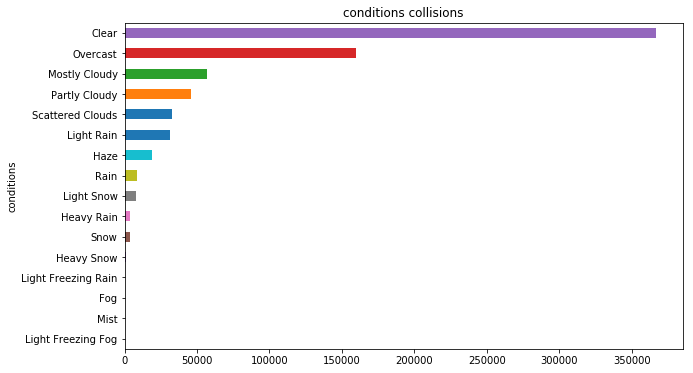

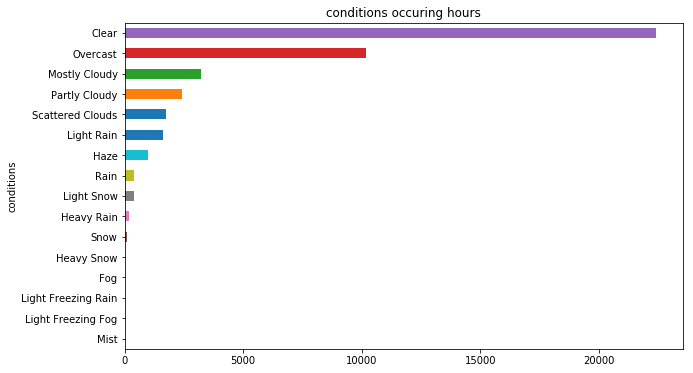

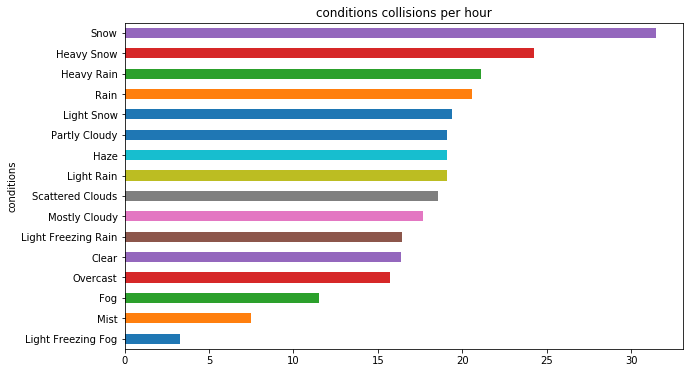

In [343]:
#----------------- categorical variable --------------------
#
colname = 'conditions' # snow, rain: has some positive impact: on collision risk 

#colname = 'winddir' # not much impact.

#mode = 'severity_index' # snow and bad weather impact is noticeably more significant/obvious w/ severity index!
mode = 'collisions'

df = cat_df(colname, cat_dict[colname], mode)

draw_df(df, colname, mode)

#save_fig(df, colname, mode)

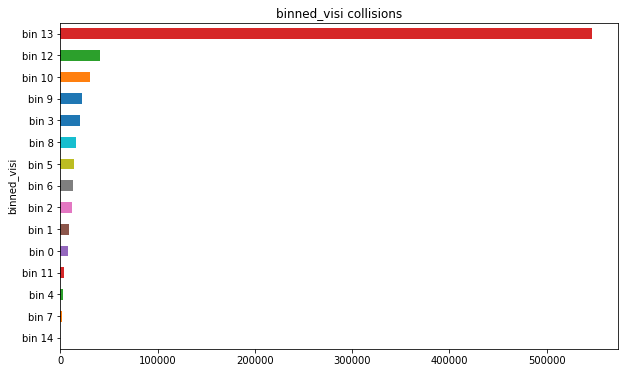

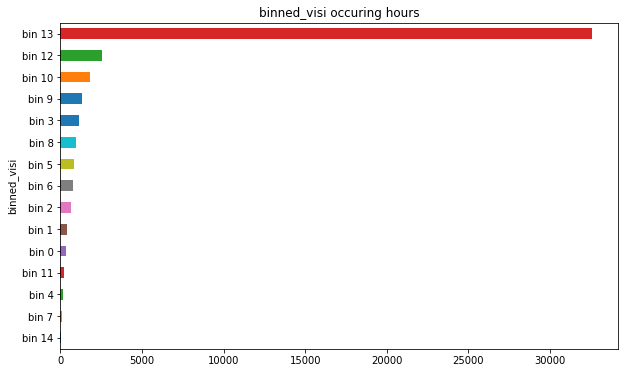

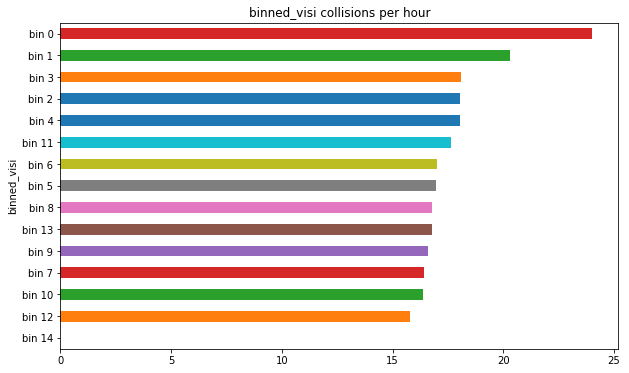

In [344]:
#----------------- numeric variable --------------------
#
colname = 'visi' # impact: low visi, higher risk
#colname = 'temp' # impact: high temp, higher risk
#colname = 'humi' # some impact: low humi, higher risk

#colname = 'dewpoint' # no much impact.

#colname = 'pressure' # not clear: need better break points:
#colname = 'windspeed' # not clear: need better break points: 95% quantile e.g. ...

#mode = 'severity_index'
mode = 'collisions'

df, colname = num_df(colname, mode)

draw_df(df, colname, mode)

#save_fig(df, colname, mode)

In [210]:
df = pd.DataFrame(np.arange(10).reshape(5,2), columns=['a', 'b'])

In [216]:
df.apply(lambda x: x['a']+x['b'], axis=1)

0     1
1     5
2     9
3    13
4    17
dtype: int64

In [215]:
df

,a,b
0,0,1
1,2,3
2,4,5
3,6,7
4,8,9


In [226]:
#----------------- calculate severity index ------------------------
mvc['severity_index'] = np.repeat(1.0, mvc.shape[0])

mvc.loc[mvc.severity == 'injured', 'severity_index'] = \
        mvc.loc[mvc.severity == 'injured', 'totInj'].\
        map(lambda x: 2.55*x)
    
mvc.loc[mvc.severity == 'fatal', 'severity_index'] = \
        mvc.loc[mvc.severity == 'fatal', ['totKill', 'totInj']].\
        apply(lambda x: 7.55*x['totKill'] + 2.55*x['totInj'], axis=1)

In [276]:
df = pd.DataFrame({'total_count': mvc['severity_index'].value_counts()})
df.sort_index(inplace=True)
df.reset_index(inplace=True)
df.rename(columns={'index': 'severity_index'}, inplace=True)
df.set_index('severity_index').head(20)

,total_count
severity_index,
1.00,601416
2.55,108225
5.10,18319
7.55,572
7.65,5992
10.10,77
10.20,2224
12.65,44
12.75,903


matplotlib.figure.Figure

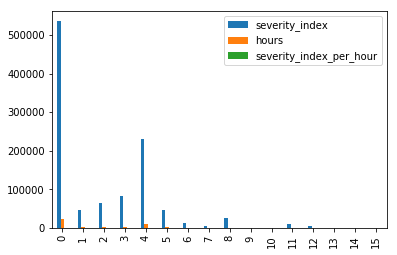

In [283]:
type(df.plot(kind='bar').figure)


In [306]:
# python - Calculation and Visualization of Correlation Matrix with Pandas - Data Science Stack Exchange
#
# https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas
# http://benalexkeen.com/correlation-in-python/
# https://stackoverflow.com/questions/44694228/how-to-check-for-correlation-among-continuous-and-categorical-variables-in-pytho?rq=1
mvc.columns

Index(['datetime', 'borough', 'lat', 'long', 'totInj', 'totKill', 'pedInj',
       'pedKill', 'cycInj', 'cycKill', 'motInj', 'motKill', 'cFactor1',
       'cFactor2', 'cFactor3', 'cFactor4', 'cFactor5', 'vType1', 'vType2',
       'vType3', 'vType4', 'vType5', 'severity', 'datehour', 'conditions',
       'dewpoint', 'humi', 'pressure', 'temp', 'visi', 'windspeed', 'winddir',
       'severity_index'],
      dtype='object')

In [311]:
df = mvc.loc[:,['totInj', 'totKill', 'visi', 'temp', 'humi', 'pressure', 'windspeed', 'dewpoint']]


In [312]:
df.corr()

,totInj,totKill,visi,temp,humi,pressure,windspeed,dewpoint
totInj,1.000000,0.021494,0.000619,0.017781,0.015464,-0.002119,-0.013078,0.022704
totKill,0.021494,1.000000,0.000294,-0.000001,0.003645,0.000015,-0.002212,0.001874
visi,0.000619,0.000294,1.000000,0.075869,-0.640199,0.162675,-0.010885,-0.196849
temp,0.017781,-0.000001,0.075869,1.000000,-0.002580,-0.215921,-0.307181,0.879966
humi,0.015464,0.003645,-0.640199,-0.002580,1.000000,-0.224664,-0.079929,0.462853
pressure,-0.002119,0.000015,0.162675,-0.215921,-0.224664,1.000000,-0.121249,-0.289371
windspeed,-0.013078,-0.002212,-0.010885,-0.307181,-0.079929,-0.121249,1.000000,-0.315705
dewpoint,0.022704,0.001874,-0.196849,0.879966,0.462853,-0.289371,-0.315705,1.000000


In [512]:
df = weather.loc[:,['visi', 'temp', 'humi', 'pressure', 'windspeed', 'dewpoint']]

In [315]:
df.corr() # pd df's corr() is way faster than np.corrcoef(df) which is NOT usable for large df!

,visi,temp,humi,pressure,windspeed,dewpoint
visi,1.000000,0.018592,-0.607172,0.184102,0.000658,-0.217120
temp,0.018592,1.000000,0.084696,-0.212657,-0.310850,0.897680
humi,-0.607172,0.084696,1.000000,-0.229786,-0.118182,0.506511
pressure,0.184102,-0.212657,-0.229786,1.000000,-0.116529,-0.276781
windspeed,0.000658,-0.310850,-0.118182,-0.116529,1.000000,-0.326103
dewpoint,-0.217120,0.897680,0.506511,-0.276781,-0.326103,1.000000


In [37]:
import seaborn as sns

# sns heatmap more nicer looking than matplotlib's matshow().
def sns_heatmap(df, size, title, save_file=None):
    corr = df.corr()    
    fig = plt.figure(figsize=(size+2,size))
    plt.title(title) # useful sometimes to put numbers over heatmap as a data table.
    sns.heatmap(corr, cmap = 'viridis', #annot=True, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)
    
    if save_file != None:
         title.replace(' ', '_')
         fig.savefig(title.replace(' ', '_') + '_sns_heatmap.png', bbox_inches='tight')   # save the figure to file
         plt.close(fig) 

In [548]:
def pick_majority(df):
    return df.loc[df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)] # highly useful to exclude outliers!

In [559]:
mvc_new.columns

Index(['datehour', 'collisions', 'severity_index',
       'Driver Inattention/Distraction', 'Failure to Yield Right-of-Way',
       'Other Vehicular', 'Backing Unsafely', 'Fatigued/Drowsy',
       'Turning Improperly', 'Lost Consciousness', 'Prescription Medication',
       'Following Too Closely', 'Driver Inexperience',
       'Traffic Control Disregarded', 'Passing or Lane Usage Improper',
       'Pavement Slippery', 'Physical Disability', 'Alcohol Involvement',
       'Outside Car Distraction', 'Unsafe Lane Changing', 'Oversized Vehicle',
       'Passenger Distraction', 'View Obstructed/Limited',
       'Reaction to Other Uninvolved Vehicle', 'Unsafe Speed',
       'Aggressive Driving/Road Rage', 'Illness', 'Brakes Defective',
       'Other Electronic Device', 'Glare',
       'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion',
       'Failure to Keep Right', 'Fell Asleep', 'PASSENGER VEHICLE',
       'SPORT UTILITY / STATION WAGON', 'TAXI', 'VAN', 'OTHER',
       'PICK-UP TRUCK

In [36]:
# df = weather.loc[:, ['collisions', 'visi', 'temp', 'humi', 'pressure', 'windspeed', 'dewpoint']]
# sns_heatmap(df, 6, 'Weather Factors vs Collisions')

# df = weather[['collisions', 'Clear', 'Cloudy', 'Fog', 'Rain', 'Snow']]
# sns_heatmap(df, 6, 'Weather Condition vs Collisions')

# df = weather[['collisions', 'Variable', 'West', 'North', 'East', 'South', 'Calm']]
# sns_heatmap(df, 6, 'Wind Direction vs Collisions', 'save')

# observations: no much correlation exists.
# humi, visi: negative corr. 
# temp, dewpoint: positive corr.
# humi, dewpoint: positive corr.

# analysis: hourly weather/collision data may be too small --> too much randomness --> too small corr
#           may change to daily record and see...

# df = mvc_new[['collisions', *top_causes, *top_vehicles]]
# sns_heatmap(df, 10, 'Top Causes and Vehicles and Collisions')

# observations:
# top 30 causes, top 15 involved vehicles:
# 1. High positive correlation: top causes, top vehicles to collisions, between each other, within each self.
# 2. Some highlights: 
#    * (following too closely, passing or lane usage improperly, unsafe lane changing) among each other,
#      with (reaction to other vehicle, unsafe speed) and (pedestrian/bicyclist/other pedestrian error/confusion)
#    * (van, other) and (small comm, bus, large comm, livery vehicle) with (fatigued/drowsy, lost consciousness, precription medication)
#    * (van, other) with (small comm, bus, large comm)
#    * note: taxi is pretty much o.k. lower correlation with others
#    * while for: pick-up truck: higher correlation w/ (sport utility/station wagon, oversized vehicle) and 
#      (following too closely, passing or lane usage improperly, unsafe lane changing) ...


# df = mvc_new[['collisions',  *top_causes, *['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'], \
#               *['totVict', 'pedVict', 'cycVict', 'motVict']]]
# sns_heatmap(df, 10, 'Top Causes and Boroughs and Victims and Collisions')

# observations: 
# no much interesting results, not as well revealing as bar and pie charts.
#


In [380]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
                                                 #fig = plt.figure(figsize=(size,size))
    fig, ax = plt.subplots(figsize=(size, size)) # plt.subplots() is a powerful layout/setup! ...     
    cax = ax.matshow(corr)
    plt.colorbar(cax)
    
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);  

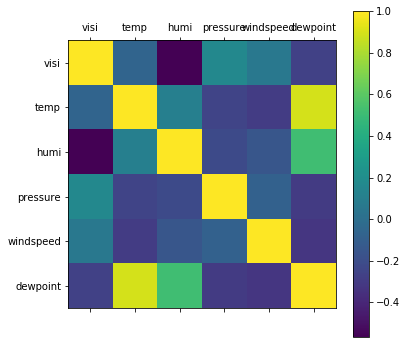

In [382]:
plot_corr(df, 6)

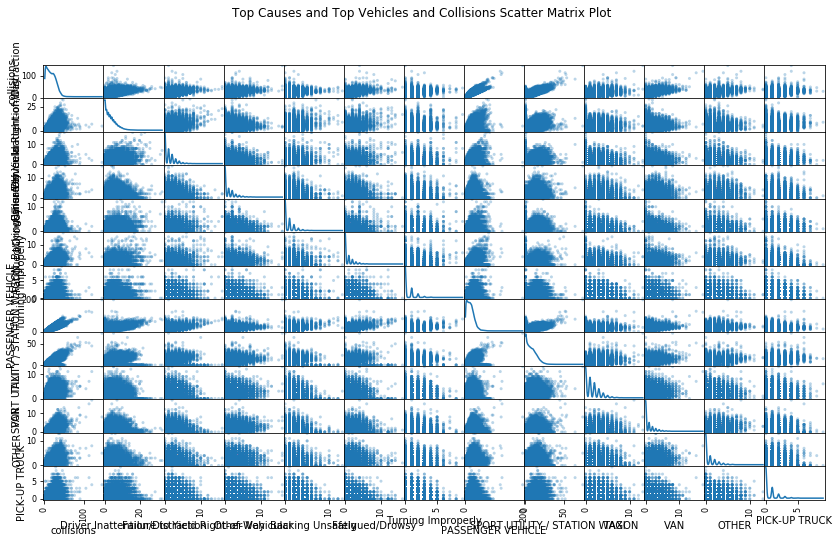

In [38]:
#df = weather.loc[:, ['collisions', 'visi', 'temp', 'humi', 'pressure', 'windspeed', 'dewpoint']]

#df = weather[['collisions', 'Clear', 'Cloudy', 'Fog', 'Rain', 'Snow']] # re-check change to daily...
#df = weather[['collisions', 'Variable', 'West', 'North', 'East', 'South', 'Calm']] # re-check change to daily...

#df = mvc_new[['collisions', *top_causes[0:6], *top_vehicles[0:6]]] # not interesting.
# pandas scatter matrix plot: 
# looks better than sns.pairplot, take some time to compute.
pd.plotting.scatter_matrix(df, alpha = 0.3, figsize = (14,8), diagonal = 'kde'); 
title = 'Top Causes and Top Vehicles and Collisions Scatter Matrix Plot'
plt.suptitle(title)

plt.savefig(title.replace(' ', '_') + '.png')

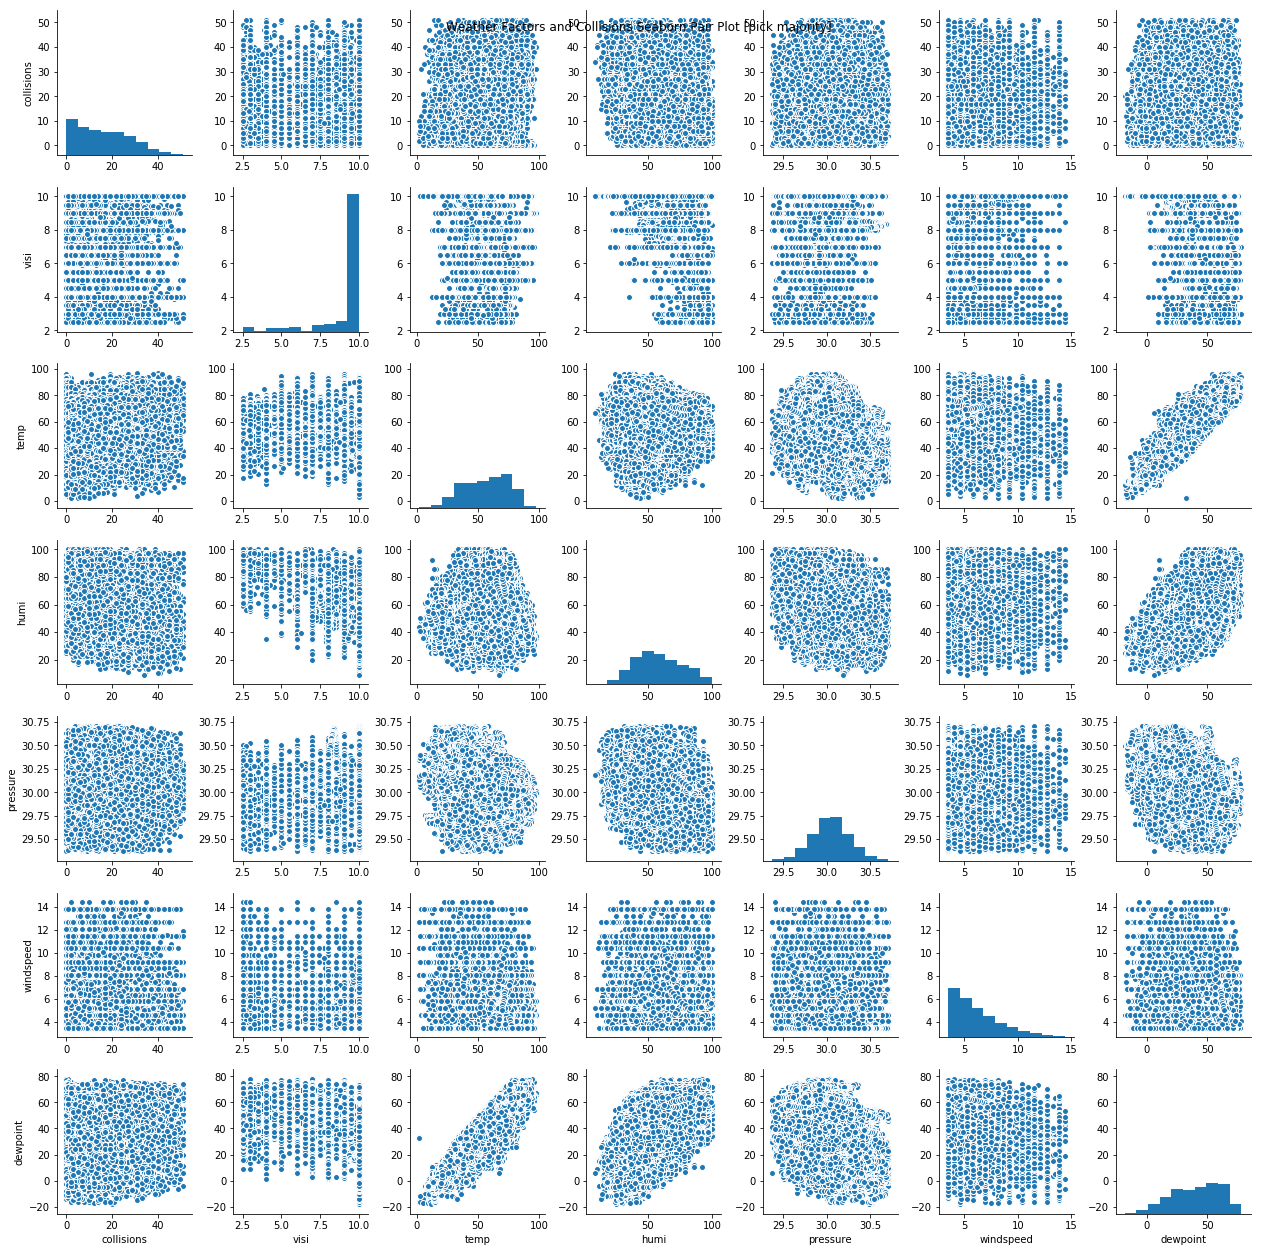

In [564]:
#If you want to visualize each feature's skewness as well - use seaborn pairplots.
df = weather.loc[:, ['collisions', 'visi', 'temp', 'humi', 'pressure', 'windspeed', 'dewpoint']]
#df = pick_majority(df)
sns.pairplot(df) # very powerful: hist/kde, sub-set of cols, linear regression, 

# title = 'Weather Factors and Collisions Seaborn Pair Plot [pick majority]'
# plt.suptitle(title)
# plt.savefig(title.replace(' ', '_') + '.png')

# Still prefer pandas scatter matrix plot: better rendering.

In [350]:
df = pick_majority(df)

In [31]:
from collections import Counter #defaultdict 

# count and find top occurred items:
def top_items(colnames, N=None):
    t_count = Counter() # defaultdict(int)

    for col in colnames:
        t_count.update(mvc[col])
        # way 2.
        # cFactor += Counter(mvc[col])
        # way3. 
        # for key, value in mvc[col].value_counts().to_dict().items():
        #    cFactor[key] += value    

    del t_count[np.nan]

    return [tup[0] for tup in t_count.most_common(N)]

colnames = ['cFactor' + str(x) for x in range(1, 6)]

top_causes = top_items(colnames, 30) # take 20 ~ [30]

# only check for top items:
for col in colnames:
    mvc[col] = pd.Categorical(mvc[col], ordered=True, categories=top_causes) 
    #mvc['cFactor1'].astype('category', ordered=True, categories=top_causes) #not working ? why? ....

# convert categorical variable into dummies for correlation analysis:
df_causes = pd.get_dummies(mvc['cFactor1'])

colnames = ['cFactor' + str(x) for x in range(2, 6)]

for col in colnames:
    df_causes = df_causes + pd.get_dummies(mvc[col])
    
# same thing for vehicles:   
    
colnames = ['vType' + str(x) for x in range(1, 6)]

top_vehicles = top_items(colnames, 15) # take [15] ~ 20

for col in colnames:
    mvc[col] = pd.Categorical(mvc[col], ordered=True, categories=top_vehicles)

df_vehicles = pd.get_dummies(mvc['vType1'])

colnames = ['vType' + str(x) for x in range(2, 6)]

for col in colnames:
    df_vehicles = df_vehicles + pd.get_dummies(mvc[col])

df_boros = pd.get_dummies(mvc['borough'])
    
mvc_new = pd.concat([mvc[['datehour', 'severity_index']], df_causes, df_vehicles, df_boros], axis=1)

mvc_new.reset_index(inplace=True)

mvc_new['totVict'] = mvc['totInj'] + mvc['totKill']
mvc_new['pedVict'] = mvc['pedInj'] + mvc['pedKill']
mvc_new['cycVict'] = mvc['cycInj'] + mvc['cycKill']
mvc_new['motVict'] = mvc['motInj'] + mvc['motKill']

#----- group by date hour and aggregate for total collisions, and sum of each col variables: ------
mvc_new = mvc_new.groupby('datehour')
df = mvc_new[['severity_index']].count().rename(columns={'severity_index': 'collisions'})
mvc_new = pd.concat([df, mvc_new.sum()], axis=1)

mvc_new.reset_index(inplace=True)

weather['conditions'].replace(to_replace=\
                              ['Overcast', 'Mostly Cloudy', 'Partly Cloudy', 'Scattered Clouds'], \
                              value='Cloudy', inplace=True)

weather['conditions'].replace(to_replace=\
                              ['Light Rain', 'Heavy Rain', 'Rain'], \
                              value='Rain', inplace=True)

weather['conditions'].replace(to_replace=\
                              ['Light Snow', 'Snow', 'Heavy Snow', 'Light Freezing Rain', 'Light Freezing Fog'], \
                              value='Snow', inplace=True)

weather['conditions'].replace(to_replace=\
                              ['Haze', 'Fog', 'Mist'], \
                              value='Fog', inplace=True)

weather['conditions'] = pd.Categorical(weather['conditions'], ordered=True, \
                                       categories=['Clear', 'Cloudy', 'Fog', 'Rain', 'Snow'])

weather['winddir'].replace(['ENE', 'East',  'ESE', 'SE'], 'East',  inplace=True)
weather['winddir'].replace(['SSE', 'South', 'SSW', 'SW'], 'South', inplace=True)
weather['winddir'].replace(['WSW', 'West',  'WNW', 'NW'], 'West',  inplace=True)
weather['winddir'].replace(['NNW', 'North', 'NNE', 'NE'], 'North', inplace=True)

weather['winddir'] = pd.Categorical(weather['winddir'], ordered=True, \
                                       categories=['Variable', 'West', 'North', 'East', 'South', 'Calm'])

df1 = pd.get_dummies(weather['conditions'])
df2 = pd.get_dummies(weather['winddir'])
    
weather = pd.concat([weather, df1, df2], axis=1)

weather_backup = weather[['datehour', 'conditions', 'winddir']]
weather.drop(['conditions', 'winddir'], axis=1, inplace=True)

weather = weather.merge(mvc_new, how='left', on='datehour')
weather.fillna(0, inplace=True)